In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir


In [2]:
data_path = './npy0/'
file_list = listdir(data_path)

In [3]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, data_path_, file_list_):
        self.data_path = data_path_
        self.file_list = file_list_
        self.len = len(file_list_)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        data = np.load( os.path.join( self.data_path, file_name ) )
        return torch.from_numpy(data['imxz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['imyz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['sig']).to(torch.long)
    def __len__(self):
        return self.len

mydataset = MyDataset(data_path, file_list)
batch_size_train = 2
batch_size_test = 4


train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)                

In [4]:
len(trainloader.dataset)

1600

In [5]:
len(testloader.dataset)

400

In [14]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 64, 5) 
        self.conv1_2 = nn.Conv2d(1, 64, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_1 = nn.Conv2d(64, 128, 5)
        self.conv2_2 = nn.Conv2d(64, 128, 5)
        self.conv3_1 = nn.Conv2d(128, 256, 6)
        self.conv3_2 = nn.Conv2d(128, 256, 6)

        self.fc1_1 = nn.Linear(256 * 108 * 44, 50)
        self.fc1_2 = nn.Linear(256 * 108 * 44, 50)
        self.fc2= nn.Linear(100, 2)

    def forward(self, x1, x2):
        # x1, x2 shape: (896, 384)      channel = 1
        x1 = self.pool(F.relu(self.conv1_1(x1))) # shape: (896, 384)->(892, 380)->(446, 190)
        x1 = self.pool(F.relu(self.conv2_1(x1))) # shape: (446, 190)->(442, 186)->(221, 93)
        x1 = self.pool(F.relu(self.conv3_1(x1))) # shape: (221, 93)->(216, 88)->(108, 44)
        x1 = torch.flatten(x1, 1) # flatten all dimensions except batch 
        x1 = F.relu(self.fc1_1(x1))

        x2 = self.pool(F.relu(self.conv1_2(x2))) # shape: (896, 384)->(892, 380)->(446, 190)
        x2 = self.pool(F.relu(self.conv2_2(x2))) # shape: (446, 190)->(442, 186)->(221, 93)
        x2 = self.pool(F.relu(self.conv3_2(x2))) # shape: (221, 93)->(216, 88)->(108, 44)
        x2 = torch.flatten(x2, 1) # flatten all dimensions except batch 
        x2 = F.relu(self.fc1_2(x2))

        return self.fc2(torch.cat((x1, x2), 1))
net=Net().cuda()

In [7]:
import torch.optim as optim

criterion_weighted = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [15]:
sum(p.numel() for p in net.parameters())

124424494

In [27]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [29]:
# Training
loss_list = []

epochs = 100

accuracy_list = []

for i in range(epochs):

    net.train() # begin training

    for (batch_idx, batch) in enumerate(trainloader):
        XZ_train_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_train_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_train_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_train_batch, YZ_train_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout))


        loss = criterion_weighted(Netout, sig_train_batch) # classification loss        
        
        # Zero the gradients before running the backward pass.
        optimizer.zero_grad() 
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0 or True:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))
    
    net.eval() # begin testing
    preds = np.array([])
    reals = np.array([])

    with torch.no_grad():
        for (batch_idx, batch) in enumerate(testloader):
            XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
            YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
            sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

            Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
            #print(Netout.shape)
            prediction=F.softmax(Netout, dim=1).argmax(dim=1)
            

            preds=np.concatenate((preds, prediction.cpu().detach().numpy().flatten()))
            reals=np.concatenate((reals, sig_test_batch.cpu().detach().numpy().flatten()))
        preds=np.array(preds)
        reals=np.array(reals)
        accuracy=np.mean(preds==reals)
        accuracy_list.append(accuracy)
        print("Test accuracy: {}".format(accuracy))


RuntimeError: CUDA out of memory. Tried to allocate 166.00 MiB (GPU 0; 6.00 GiB total capacity; 4.10 GiB already allocated; 0 bytes free; 4.28 GiB reserved in total by PyTorch)

In [1]:
accuracy_list

NameError: name 'accuracy_list' is not defined

In [9]:
with torch.no_grad():
    net.eval()
    # Prediction
    preds = np.array([])
    reals = np.array([])

    for (batch_idx, batch) in enumerate(testloader):
        XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
        #print(Netout.shape)
        prediction=F.softmax(Netout, dim=1).argmax(dim=1)
        

        preds=np.concatenate((preds, prediction.cpu().detach().numpy().flatten()))
        #preds=np.ones((400))
        reals=np.concatenate((reals, sig_test_batch.cpu().detach().numpy().flatten()))
    preds=np.array(preds)
    reals=np.array(reals)


C:\Users\swyx2\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


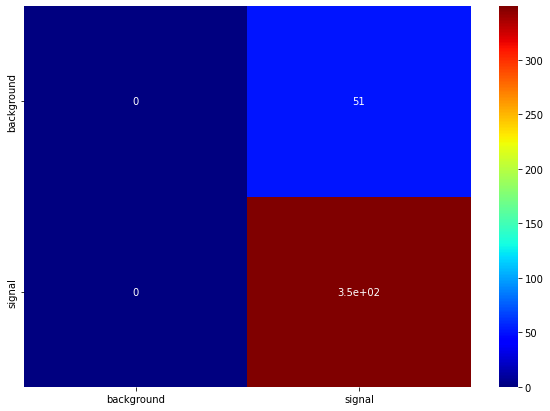

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(reals.flatten(), preds.flatten()), index = ['background', 'signal'],
                  columns = ['background', 'signal'])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.heatmap(df_cm, annot=True, cmap="jet")
plt.show()

# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [11]:
np.sum(reals==preds)

349

In [26]:
torch.save(net, './model_save_train.pth')

In [16]:
net = torch.load('./model_save_train.pth')
